In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
# from torchvision.transforms import ToTensor, ToPILImage
import torchvision.transforms as transforms
from collections import Counter
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torchvision.models as models

In [2]:
sem_df=pd.read_excel("SEM_Final.xlsx")
print(sem_df.shape)
sem_df.head()

(1603, 15)


,link,title,num,letter,hydrogel,sentence,figure,SEM,SEM_img,scale,modulus,measurement,modification,skip,Unnamed: 14
0,https://pubs.acs.org/doi/10.1021/acsami.5b00184,Tough and Biocompatible Hydrogels Based on in ...,S3.,a,PVA,SEM images of the dehydrated PVA,sem/10.1021_acsami.5b00184\supp_7.jpg,sem/10.1021_acsami.5b00184\SEM,supp_7_SEM3.jpg,-5.0,compressive,42.3 kPa,NaN,NaN,NaN
1,https://pubs.acs.org/doi/10.1021/acsami.5b00185,Tough and Biocompatible Hydrogels Based on in ...,S3.,a,PVA,SEM images of the dehydrated PVA,sem/10.1021_acsami.5b00184\supp_7.jpg,sem/10.1021_acsami.5b00184\SEM,supp_7_SEM5.jpg,-6.0,compressive,42.3 kPa,NaN,NaN,NaN
2,https://pubs.acs.org/doi/10.1021/acsami.5b00186,Tough and Biocompatible Hydrogels Based on in ...,S3.,b,E-cGO0.5/PVA-2,and E-cGO/PVA-2IPN hydrogels with E-cGO con...,sem/10.1021_acsami.5b00184\supp_7.jpg,sem/10.1021_acsami.5b00184\SEM,supp_7_SEM1.jpg,-5.0,compressive,60 kPa,NaN,NaN,NaN
3,https://pubs.acs.org/doi/10.1021/acsami.5b00187,Tough and Biocompatible Hydrogels Based on in ...,S3.,b,E-cGO0.5/PVA-2,and E-cGO/PVA-2IPN hydrogels with E-cGO con...,sem/10.1021_acsami.5b00184\supp_7.jpg,sem/10.1021_acsami.5b00184\SEM,supp_7_SEM0.jpg,-6.0,compressive,60 kPa,NaN,NaN,NaN
4,https://pubs.acs.org/doi/10.1021/acsami.5b00188,Tough and Biocompatible Hydrogels Based on in ...,S3.,c,E-cGO1.0/PVA-2,and E-cGO/PVA-2IPN hydrogels with E-cGO con...,sem/10.1021_acsami.5b00184\supp_7.jpg,sem/10.1021_acsami.5b00184\SEM,supp_7_SEM6.jpg,-5.0,compressive,60 kPa,NaN,NaN,NaN


In [3]:
sem_df.isna().sum()

link               0
title              0
num                0
letter             4
hydrogel           0
sentence          16
figure             0
SEM                0
SEM_img          746
scale            743
modulus          766
measurement      772
modification    1603
skip             796
Unnamed: 14     1414
dtype: int64

In [4]:
measure_sem_df = sem_df[sem_df['skip'].isna()]
measure_sem_df = measure_sem_df[measure_sem_df['measurement'].isna()]
print(measure_sem_df.shape)
measure_sem_df.to_csv("missing_measurement.csv")
measure_sem_df.head()

(0, 15)


,link,title,num,letter,hydrogel,sentence,figure,SEM,SEM_img,scale,modulus,measurement,modification,skip,Unnamed: 14


In [5]:
parsed_sem_df = sem_df[sem_df['measurement'].notna()]
parsed_sem_df = parsed_sem_df[parsed_sem_df['SEM_img'].notna()]
print(parsed_sem_df['skip'].isna().sum())
parsed_sem_df = parsed_sem_df[parsed_sem_df['skip'].isna()]
print(parsed_sem_df.shape)
parsed_sem_df.head()

793
(793, 15)


,link,title,num,letter,hydrogel,sentence,figure,SEM,SEM_img,scale,modulus,measurement,modification,skip,Unnamed: 14
0,https://pubs.acs.org/doi/10.1021/acsami.5b00184,Tough and Biocompatible Hydrogels Based on in ...,S3.,a,PVA,SEM images of the dehydrated PVA,sem/10.1021_acsami.5b00184\supp_7.jpg,sem/10.1021_acsami.5b00184\SEM,supp_7_SEM3.jpg,-5.0,compressive,42.3 kPa,NaN,NaN,NaN
1,https://pubs.acs.org/doi/10.1021/acsami.5b00185,Tough and Biocompatible Hydrogels Based on in ...,S3.,a,PVA,SEM images of the dehydrated PVA,sem/10.1021_acsami.5b00184\supp_7.jpg,sem/10.1021_acsami.5b00184\SEM,supp_7_SEM5.jpg,-6.0,compressive,42.3 kPa,NaN,NaN,NaN
2,https://pubs.acs.org/doi/10.1021/acsami.5b00186,Tough and Biocompatible Hydrogels Based on in ...,S3.,b,E-cGO0.5/PVA-2,and E-cGO/PVA-2IPN hydrogels with E-cGO con...,sem/10.1021_acsami.5b00184\supp_7.jpg,sem/10.1021_acsami.5b00184\SEM,supp_7_SEM1.jpg,-5.0,compressive,60 kPa,NaN,NaN,NaN
3,https://pubs.acs.org/doi/10.1021/acsami.5b00187,Tough and Biocompatible Hydrogels Based on in ...,S3.,b,E-cGO0.5/PVA-2,and E-cGO/PVA-2IPN hydrogels with E-cGO con...,sem/10.1021_acsami.5b00184\supp_7.jpg,sem/10.1021_acsami.5b00184\SEM,supp_7_SEM0.jpg,-6.0,compressive,60 kPa,NaN,NaN,NaN
4,https://pubs.acs.org/doi/10.1021/acsami.5b00188,Tough and Biocompatible Hydrogels Based on in ...,S3.,c,E-cGO1.0/PVA-2,and E-cGO/PVA-2IPN hydrogels with E-cGO con...,sem/10.1021_acsami.5b00184\supp_7.jpg,sem/10.1021_acsami.5b00184\SEM,supp_7_SEM6.jpg,-5.0,compressive,60 kPa,NaN,NaN,NaN


In [6]:
parsed_sem_df['skip'].value_counts()

Series([], Name: skip, dtype: int64)

In [7]:
parsed_sem_df.isna().sum()

link              0
title             0
num               0
letter            4
hydrogel          0
sentence          8
figure            0
SEM               0
SEM_img           0
scale             4
modulus           0
measurement       0
modification    793
skip            793
Unnamed: 14     712
dtype: int64

In [8]:
missing_sem_df = parsed_sem_df[parsed_sem_df['SEM_img'].isna()]
# missing_sem_df.to_csv("missing_sem_rows.csv")
missing_sem_df.head(40) 

,link,title,num,letter,hydrogel,sentence,figure,SEM,SEM_img,scale,modulus,measurement,modification,skip,Unnamed: 14


In [9]:
missing_sem_df['skip'].value_counts()

Series([], Name: skip, dtype: int64)

In [10]:
parsed_sem_df['img_path'] = parsed_sem_df.apply(lambda x: os.path.join(x['SEM'],x['SEM_img']),axis=1)

In [11]:
parsed_sem_df['img_path']

0          sem/10.1021_acsami.5b00184\SEM\supp_7_SEM3.jpg
1          sem/10.1021_acsami.5b00184\SEM\supp_7_SEM5.jpg
2          sem/10.1021_acsami.5b00184\SEM\supp_7_SEM1.jpg
3          sem/10.1021_acsami.5b00184\SEM\supp_7_SEM0.jpg
4          sem/10.1021_acsami.5b00184\SEM\supp_7_SEM6.jpg
                              ...                        
1598    sem/10.1021_acs.langmuir.8b02918\SEM\la-2018-0...
1599    sem/10.1021_acs.langmuir.8b02918\SEM\la-2018-0...
1600    sem/10.1021_acsbiomaterials.0c00143\SEM\ab0c00...
1601    sem/10.1021_acsbiomaterials.0c00143\SEM\ab0c00...
1602    sem/10.1021_acsbiomaterials.0c00143\SEM\ab0c00...
Name: img_path, Length: 793, dtype: object

In [12]:
# clean dataset to get correct labels
parsed_sem_df['measurement']

def convert_measurement(string):
    string.replace(" ","")
    kpa = ["KPa","kPa", "Kpa", "kpa","KpA"]
    mpa = ["Mpa","MPa"]
    gpa = ["GPa","Gpa"]
    
    if any(KPA in string for KPA in kpa):
        for KPA in kpa:
            string = string.replace(KPA,"")
        string = string.strip()
        value = float(string)
        value *= 1000 
    elif any(MPA in string for MPA in mpa):
        for MPA in mpa:
            string = string.replace(MPA,"")
        string = string.strip()
        value = float(string)
        value *= 1000000
    elif any(GPA in string for GPA in gpa):
        for GPA in gpa:
            string = string.replace(GPA,"")
        string = string.strip()
        value = float(string)
        value *= 1000000000
    elif "Pa" in string:
        string = string.replace("Pa","")
        string = string.strip()
        value = float(string)
    else:
        print(string)
        return
    return value
parsed_sem_df['measurement'].apply(convert_measurement)

0        42300.0
1        42300.0
2        60000.0
3        60000.0
4        60000.0
          ...   
1598    157000.0
1599    162000.0
1600      8000.0
1601     50000.0
1602    120000.0
Name: measurement, Length: 793, dtype: float64

In [13]:
transform = transforms.Compose(
    [transforms.Resize(256),
#     transforms.Grayscale(3),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(0,1)
    ]
)
eval_transform = transform = transforms.Compose(
    [transforms.Resize(256),
#     transforms.Grayscale(3),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0,1)
    ]
)

793
(793, 16)
Length: 793


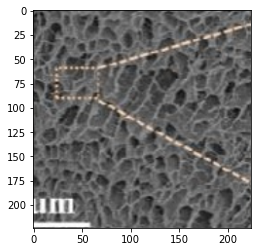

In [14]:
class semDataset(Dataset):
    def __init__(self,filepath="SEM_Final.xlsx", transform = None):
        sem_df=pd.read_excel("SEM_Final.xlsx")
        parsed_sem_df = sem_df[sem_df['measurement'].notna()]
        parsed_sem_df = parsed_sem_df[parsed_sem_df['SEM_img'].notna()]
        print(parsed_sem_df['skip'].isna().sum())
        parsed_sem_df = parsed_sem_df[parsed_sem_df['skip'].isna()]
        parsed_sem_df['img_path'] = parsed_sem_df.apply(lambda x: os.path.join(x['SEM'],x['SEM_img']),axis=1)
        print(parsed_sem_df.shape)
        parsed_sem_df['measurement']= parsed_sem_df['measurement'].apply(self.convert_measurement)
        self.sem_df = parsed_sem_df
        self.transform = transform
    
    def __len__(self):
        return parsed_sem_df.shape[0]
    
    def convert_measurement(self,string):
        string.replace(" ","")
        kpa = ["KPa","kPa", "Kpa", "kpa","KpA"]
        mpa = ["Mpa","MPa"]
        gpa = ["GPa","Gpa"]

        if any(KPA in string for KPA in kpa):
            for KPA in kpa:
                string = string.replace(KPA,"")
            string = string.strip()
            value = float(string)
            value *= 1000 
        elif any(MPA in string for MPA in mpa):
            for MPA in mpa:
                string = string.replace(MPA,"")
            string = string.strip()
            value = float(string)
            value *= 1000000
        elif any(GPA in string for GPA in gpa):
            for GPA in gpa:
                string = string.replace(GPA,"")
            string = string.strip()
            value = float(string)
            value *= 1000000000
        elif "Pa" in string:
            string = string.replace("Pa","")
            string = string.strip()
            value = float(string)
        else:
            print(string)
            return
        return np.log10(value)
    def __getitem__(self,index):
        image = Image.open(self.sem_df.iloc[index]["img_path"])
        label = self.sem_df.iloc[index]["measurement"]
        if self.transform is not None:
            image = self.transform(image)
        label = torch.tensor(label)
        return image, label
semdata = semDataset(transform=transform)
print(f"Length: {len(semdata)}")
image, label=semdata.__getitem__(0)
plt.imshow(image.permute(1,2,0))

In [15]:
# Create train test split, as 60/20/20 split
train_idx, test_idx = train_test_split(list(range(len(semdata))),test_size = 0.2, random_state=42)
train_idx, val_idx =  train_test_split(train_idx, test_size = 0.25, random_state=42)
train_data = torch.utils.data.Subset(semDataset(transform=transform),train_idx)
val_data = torch.utils.data.Subset(semDataset(transform=eval_transform),val_idx)
test_data = torch.utils.data.Subset(semDataset(transform=eval_transform),test_idx)
print(f"Train dataset length: {len(train_data)}")
print(f"Validation dataset length: {len(val_data)}")
print(f"Test dataset length: {len(test_data)}")

793
(793, 16)
793
(793, 16)
793
(793, 16)
Train dataset length: 475
Validation dataset length: 159
Test dataset length: 159


In [16]:
batch_size = 10
train_loader = DataLoader(train_data, batch_size=batch_size, 
                          shuffle=True, num_workers=0, persistent_workers=False)
val_loader = DataLoader(val_data, batch_size=batch_size*4, 
                          shuffle=False, num_workers=0, persistent_workers=False)
test_loader = DataLoader(test_data, batch_size=batch_size*4, 
                          shuffle=False, num_workers=0, persistent_workers=False)

In [17]:
resolution = []
cannot_open = []
low_res = []
to_pil = transforms.ToPILImage()
for i in range(len(semdata)):
    try:
        image, label=semdata.__getitem__(i)
#         image = image.permute(1,2,0)
        image = to_pil(image)
        if image.size[0]<128 or image.size[1]<128:
            low_res.append(i)
        resolution.append(image.size)
    except:
        print(parsed_sem_df.iloc[i,:]["img_path"])
        cannot_open.append(i)
        print(f"Cannot open {i}")
parsed_sem_df.iloc[cannot_open,:].to_csv("cannot_open.csv")
print(f"We cannot open {len(cannot_open)} files")
print(f"Smallest resolution is {min(resolution)}")
print(f"Largest resolution is {max(resolution)}")

We cannot open 0 files
Smallest resolution is (224, 224)
Largest resolution is (224, 224)


In [18]:
low_res

[]

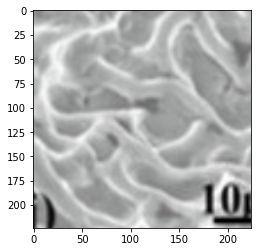

In [19]:
plt.imshow(semdata.__getitem__(615)[0].permute(1,2,0))

In [20]:
type(semdata.__getitem__(615)[0])

torch.Tensor

In [21]:
# Define a model

class SEMPro(torch.nn.Module):
    def __init__(self):
        super(SEMPro,self).__init__()
        self.cnn_block = torch.nn.Sequential(
            torch.nn.Conv2d(1,16,kernel_size=3,stride=2),
            torch.nn.ELU(inplace=True),
            torch.nn.MaxPool2d(2),
            torch.nn.BatchNorm2d(16),
            torch.nn.Conv2d(16,8,kernel_size=3,stride=2),
            torch.nn.ELU(inplace=True),
            torch.nn.MaxPool2d(2),
            torch.nn.BatchNorm2d(8)         
        )
        
        self.linear_layer = torch.nn.Sequential(
            torch.nn.LazyLinear(64),
            torch.nn.ELU(inplace=True),
            torch.nn.BatchNorm1d(64),
            torch.nn.Linear(64,32),
            torch.nn.BatchNorm1d(32),
            torch.nn.ELU(inplace=True),
            torch.nn.Linear(32,1)
        )
    
    def forward(self, x):
        x = self.cnn_block(x)
#         print(x.shape)
        x = x.view(x.size(0),-1)
#         print(x.shape)
        x = self.linear_layer(x)
        return x

In [22]:
class SEMPro_resNext(torch.nn.Module):
    def __init__(self,fc_size = 2048,large = False, pretrained = False):
        super(SEMPro_resNext,self).__init__()
        if large:
            self.model = models.resnext101_32x8d(pretrained=pretrained)
        else:
            self.model = models.resnext50_32x4d(pretrained=pretrained)
        self.model.fc = torch.nn.Linear(fc_size,1)
        # Change relu to elu
        self.replace_layers(self.model, torch.nn.ReLU, torch.nn.ELU())
    def forward(self,x):
        x = self.model(x)
        return x
    ## From https://stackoverflow.com/questions/58297197/how-to-change-activation-layer-in-pytorch-pretrained-module
    def replace_layers(self, model, old, new):
        for n, module in model.named_children():
            if len(list(module.children())) > 0:
                ## compound module, go inside it
                self.replace_layers(module, old, new)
            if isinstance(module, old):
                ## simple module
                setattr(model, n, new)

In [23]:
model = SEMPro_resNext()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-6, weight_decay = 0.02)
criterion = torch.nn.L1Loss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20,gamma=0.5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")
model.to(device)
criterion.to(device)
print(model)
# 1/0
# print(semdata.__getitem__(615))
# model.eval()
# print(model.forward(semdata.__getitem__(615)[0].unsqueeze(0).to(device)))
# model.train()

Running on cuda
SEMPro_resNext(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ELU(alpha=1.0)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ELU(alpha=1.0)
        (downs

In [24]:
epochs = 100
print(f"Training for {epochs} epochs")

# training loop
train_mae_loss_list = []
train_mse_loss_list = []
val_mae_loss_list = []
val_mse_loss_list = []
best_mae = 1000000
for epoch in range(epochs):
    print(f"Now running epoch {epoch}")
    #Iterate through training dataset
    train_mae_loss = 0
    train_mse_loss = 0
    val_mae_loss = 0
    val_mse_loss = 0
    model.train()
    for image, label in tqdm(train_loader,desc="Training data: "):
        # Send variables to device
        image = image.to(device)
        label = label.to(device)
        # Zero gradients
        optimizer.zero_grad()
        # Predict values
        pred = model(image)
        # Compute loss
        loss = criterion(pred.squeeze(),label)
        # Backpropagate
        loss.backward()
        # Update parameters
        optimizer.step()
        # Move variables to cpu
        pred = pred.cpu().detach()
        label = label.cpu().detach()
        # Compute losses
        train_mae_loss += mean_absolute_error(pred,label)*image.shape[0]
        train_mse_loss += mean_squared_error(pred,label)*image.shape[0]
    train_mae_loss /= len(train_data)
    train_mse_loss /= len(train_data)
    model.eval()
    # Run validation dataset
    for image, label in tqdm(val_loader,desc="Validation data: "):
        # Send variables to device
        image = image.to(device)
        label = label.to(device)
        # Run model
        pred = model(image)
        # Move variables to cpu
        pred = pred.cpu().detach()
        label = label.cpu().detach()
        # Compute loss
        val_mae_loss += mean_absolute_error(pred,label)*image.shape[0]
        val_mse_loss += mean_squared_error(pred,label)*image.shape[0]
    val_mae_loss /= len(val_data)
    val_mse_loss /= len(val_data)
    print(f"Training losses: MAE = {train_mae_loss}, MSE = {train_mse_loss}")
    print(f"Validation losses: MAE = {val_mae_loss}, MSE = {val_mse_loss}")
    train_mae_loss_list.append(train_mae_loss)
    train_mse_loss_list.append(train_mse_loss)
    val_mae_loss_list.append(val_mae_loss)
    val_mse_loss_list.append(val_mse_loss)
    scheduler.step()
    # Checkpoint best model
    if val_mae_loss < best_mae:
        best_mae = val_mae_loss
        torch.save(model, f"best_resnext_model.pt")

Training for 100 epochs
Now running epoch 0


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Training losses: MAE = 5.091997988250272, MSE = 27.720839518254078
Validation losses: MAE = 3.8362229905124825, MSE = 16.766882956113527
Now running epoch 1


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.30it/s]


Training losses: MAE = 4.297399852855001, MSE = 20.40705450529295
Validation losses: MAE = 3.2444880066024777, MSE = 13.200894179704006
Now running epoch 2


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Training losses: MAE = 2.801764528783623, MSE = 10.192186638492046
Validation losses: MAE = 1.7169736761572496, MSE = 4.514582986032811
Now running epoch 3


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Training losses: MAE = 1.4216194712295596, MSE = 3.2106957505156095
Validation losses: MAE = 1.1400611586779503, MSE = 2.15962916323321
Now running epoch 4


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Training losses: MAE = 1.0795756610370992, MSE = 1.978079773451544
Validation losses: MAE = 1.1941106501621448, MSE = 2.1798858127000718
Now running epoch 5


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s]


Training losses: MAE = 1.0514813124381062, MSE = 1.8375829999119124
Validation losses: MAE = 1.2328522423773836, MSE = 2.296470630708963
Now running epoch 6


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Training losses: MAE = 0.9989660799063806, MSE = 1.6558936952060126
Validation losses: MAE = 1.172430848650081, MSE = 2.1106854892907916
Now running epoch 7


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.17it/s]


Training losses: MAE = 0.9637150721988026, MSE = 1.6160358223962747
Validation losses: MAE = 1.0930855071001877, MSE = 1.8873822304334402
Now running epoch 8


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Training losses: MAE = 0.9228713685881731, MSE = 1.474640363217804
Validation losses: MAE = 1.1463121674751866, MSE = 2.0149968285577176
Now running epoch 9


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Training losses: MAE = 0.8869788223958798, MSE = 1.371981746694672
Validation losses: MAE = 1.0910199800370894, MSE = 1.9051085549548503
Now running epoch 10


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Training losses: MAE = 0.8658878149209127, MSE = 1.350967983914129
Validation losses: MAE = 1.0839857768901873, MSE = 1.8733937766803066
Now running epoch 11


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Training losses: MAE = 0.8325006325326044, MSE = 1.3099008319728924
Validation losses: MAE = 1.0929189809465112, MSE = 1.861033510852513
Now running epoch 12


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Training losses: MAE = 0.8350020019192276, MSE = 1.2556935516205396
Validation losses: MAE = 1.1036047403231035, MSE = 1.932954345848323
Now running epoch 13


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Training losses: MAE = 0.744481733399115, MSE = 1.1005323259402984
Validation losses: MAE = 1.0628412760919477, MSE = 1.7641382931625758
Now running epoch 14


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.30it/s]


Training losses: MAE = 0.7581409091621885, MSE = 1.1707567790685334
Validation losses: MAE = 1.0836728420403463, MSE = 1.836184636759617
Now running epoch 15


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Training losses: MAE = 0.7502512764293252, MSE = 1.1274533369196102
Validation losses: MAE = 1.0880168308277636, MSE = 2.0409427146859382
Now running epoch 16


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.41it/s]


Training losses: MAE = 0.7348574106950565, MSE = 1.043473797047515
Validation losses: MAE = 1.0595865115443959, MSE = 1.7426757923394554
Now running epoch 17


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.41it/s]


Training losses: MAE = 0.6716118840448492, MSE = 0.9372709610282606
Validation losses: MAE = 1.1229241644813182, MSE = 1.9170667816515812
Now running epoch 18


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.41it/s]


Training losses: MAE = 0.6338037212876745, MSE = 0.8235062824502976
Validation losses: MAE = 1.1066300156470075, MSE = 2.0665500470105074
Now running epoch 19


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28it/s]


Training losses: MAE = 0.6244487220865294, MSE = 0.8467498896262862
Validation losses: MAE = 1.1185461908344365, MSE = 1.9298430428119708
Now running epoch 20


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]


Training losses: MAE = 0.6094714257915421, MSE = 0.8124858074857536
Validation losses: MAE = 1.0627425391503071, MSE = 1.8426738075489544
Now running epoch 21


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Training losses: MAE = 0.6048156229413825, MSE = 0.7953530104376876
Validation losses: MAE = 1.050132896914846, MSE = 1.7831729867383401
Now running epoch 22


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.46it/s]


Training losses: MAE = 0.5762117293117195, MSE = 0.7014258840270073
Validation losses: MAE = 1.1104870393517043, MSE = 1.9897015367576676
Now running epoch 23


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]


Training losses: MAE = 0.586851330824709, MSE = 0.718961603253737
Validation losses: MAE = 1.1252180212890612, MSE = 1.8765984180510733
Now running epoch 24


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.54it/s]


Training losses: MAE = 0.537208348106927, MSE = 0.6764089128717469
Validation losses: MAE = 1.077673510251849, MSE = 1.9126539329170316
Now running epoch 25


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]


Training losses: MAE = 0.5239497179445994, MSE = 0.6266407145618605
Validation losses: MAE = 1.0533036103829787, MSE = 1.7965716432645586
Now running epoch 26


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


Training losses: MAE = 0.4920120891133959, MSE = 0.5776184185288257
Validation losses: MAE = 1.0650366788358854, MSE = 1.8653126390071386
Now running epoch 27


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Training losses: MAE = 0.5175196143042423, MSE = 0.5886121417311951
Validation losses: MAE = 1.0704132061318268, MSE = 1.8050952596889893
Now running epoch 28


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.53it/s]


Training losses: MAE = 0.5575725129787953, MSE = 0.6538756350605246
Validation losses: MAE = 1.0469171529588202, MSE = 1.670720724711316
Now running epoch 29


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.49it/s]


Training losses: MAE = 0.5199757626022232, MSE = 0.5596482433880924
Validation losses: MAE = 1.063425388296496, MSE = 1.8546342750766882
Now running epoch 30


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]


Training losses: MAE = 0.5045528543688106, MSE = 0.5525996111650965
Validation losses: MAE = 1.0861159641825813, MSE = 1.7820015172175059
Now running epoch 31


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.35it/s]


Training losses: MAE = 0.5141164397235641, MSE = 0.5618723330244222
Validation losses: MAE = 1.0732405928753252, MSE = 1.8470929579517388
Now running epoch 32


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]


Training losses: MAE = 0.5842859767762237, MSE = 0.6712705579676992
Validation losses: MAE = 1.050071762316907, MSE = 1.7052603981906729
Now running epoch 33


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.38it/s]


Training losses: MAE = 0.49536604850314014, MSE = 0.5176174404548549
Validation losses: MAE = 1.0588258250558338, MSE = 1.8405359153861023
Now running epoch 34


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.38it/s]


Training losses: MAE = 0.48820452492538713, MSE = 0.5394743747704486
Validation losses: MAE = 1.055935321102666, MSE = 1.7216480445114644
Now running epoch 35


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.33it/s]


Training losses: MAE = 0.4713252072659801, MSE = 0.47338396944280914
Validation losses: MAE = 1.060254387646766, MSE = 1.741614188316101
Now running epoch 36


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Training losses: MAE = 0.5148692699805765, MSE = 0.5572583070182074
Validation losses: MAE = 1.1271256355842798, MSE = 1.9412487814561779
Now running epoch 37


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.36it/s]


Training losses: MAE = 0.4757152552945978, MSE = 0.5013075136999567
Validation losses: MAE = 1.0638828287547275, MSE = 1.8326333671733015
Now running epoch 38


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.36it/s]


Training losses: MAE = 0.45224188349517014, MSE = 0.43293602743268306
Validation losses: MAE = 1.081661752933479, MSE = 1.7971130026859299
Now running epoch 39


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.35it/s]


Training losses: MAE = 0.4711003707387346, MSE = 0.46656526524237757
Validation losses: MAE = 1.084879066366994, MSE = 1.853879933407002
Now running epoch 40


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.33it/s]


Training losses: MAE = 0.4771427364971934, MSE = 0.4751714534867854
Validation losses: MAE = 1.1111650337840135, MSE = 1.868011808322882
Now running epoch 41


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.35it/s]


Training losses: MAE = 0.46373282689034234, MSE = 0.4240687141685302
Validation losses: MAE = 1.0912664826612388, MSE = 1.8156325172338934
Now running epoch 42


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.36it/s]


Training losses: MAE = 0.47579690386174156, MSE = 0.49023113598311563
Validation losses: MAE = 1.0674030871601738, MSE = 1.759845704648357
Now running epoch 43


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Training losses: MAE = 0.43415694765227053, MSE = 0.4147666361219577
Validation losses: MAE = 1.079039973758265, MSE = 1.7626729611044232
Now running epoch 44


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]


Training losses: MAE = 0.45904272856419065, MSE = 0.45701086515665673
Validation losses: MAE = 1.0654407470415292, MSE = 1.7944661141809417
Now running epoch 45


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]


Training losses: MAE = 0.4851116849043722, MSE = 0.4720434916231971
Validation losses: MAE = 1.0654024478991335, MSE = 1.7397050012120299
Now running epoch 46


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Training losses: MAE = 0.4938012532338898, MSE = 0.48780678844436687
Validation losses: MAE = 1.0631651099341373, MSE = 1.7743973758682425
Now running epoch 47


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Training losses: MAE = 0.5015190493657715, MSE = 0.4977526648765464
Validation losses: MAE = 1.0952378631349629, MSE = 1.7855448911000202
Now running epoch 48


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28it/s]


Training losses: MAE = 0.4634824845073463, MSE = 0.4527936076832721
Validation losses: MAE = 1.0504173434403141, MSE = 1.7417862165596563
Now running epoch 49


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28it/s]


Training losses: MAE = 0.4134572749490323, MSE = 0.37702993097745424
Validation losses: MAE = 1.0544469697700312, MSE = 1.7476815742989738
Now running epoch 50


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Training losses: MAE = 0.4259584764153139, MSE = 0.408492572225998
Validation losses: MAE = 1.061549412369424, MSE = 1.7679377891328831
Now running epoch 51


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Training losses: MAE = 0.45858509114952395, MSE = 0.4315097079000253
Validation losses: MAE = 1.0756270635826963, MSE = 1.8139093388052707
Now running epoch 52


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Training losses: MAE = 0.46327243784540145, MSE = 0.4599941662590805
Validation losses: MAE = 1.11634802956717, MSE = 1.8785346967860923
Now running epoch 53


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Training losses: MAE = 0.43814372450674427, MSE = 0.42139108065181013
Validation losses: MAE = 1.069613936055858, MSE = 1.7692958447192617
Now running epoch 54


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Training losses: MAE = 0.42419114900594557, MSE = 0.44167591651196597
Validation losses: MAE = 1.0410613809550024, MSE = 1.6856648662076776
Now running epoch 55


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Training losses: MAE = 0.4173761684763849, MSE = 0.3814034644748812
Validation losses: MAE = 1.0433863161165657, MSE = 1.6970773918714768
Now running epoch 56


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.38it/s]


Training losses: MAE = 0.40789194424853153, MSE = 0.37784349286164476
Validation losses: MAE = 1.0770260295003367, MSE = 1.7729617371619744
Now running epoch 57


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Training losses: MAE = 0.40605511293561775, MSE = 0.3513937620550145
Validation losses: MAE = 1.0917413751352651, MSE = 1.8007238783211927
Now running epoch 58


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.30it/s]


Training losses: MAE = 0.4499286387493258, MSE = 0.4226569299243098
Validation losses: MAE = 1.0551436724634962, MSE = 1.780774139924117
Now running epoch 59


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


Training losses: MAE = 0.38235346265603903, MSE = 0.3389429049377671
Validation losses: MAE = 1.0541373793557258, MSE = 1.7512164656803804
Now running epoch 60


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


Training losses: MAE = 0.4566448444953038, MSE = 0.4372878668484198
Validation losses: MAE = 1.0731294597234202, MSE = 1.7773290971077356
Now running epoch 61


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.36it/s]


Training losses: MAE = 0.45163458402192735, MSE = 0.4399931458895016
Validation losses: MAE = 1.039984043866907, MSE = 1.6996361162966185
Now running epoch 62


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Training losses: MAE = 0.41249365701474694, MSE = 0.35657685659512606
Validation losses: MAE = 1.0557113051300346, MSE = 1.7506816142046326
Now running epoch 63


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Training losses: MAE = 0.4210863386032379, MSE = 0.394525302579114
Validation losses: MAE = 1.092496812017443, MSE = 1.853920079577432
Now running epoch 64


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.45it/s]


Training losses: MAE = 0.4323101247910311, MSE = 0.3915844961548085
Validation losses: MAE = 1.0480759185353152, MSE = 1.7211211986291646
Now running epoch 65


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.35it/s]


Training losses: MAE = 0.4476976951588416, MSE = 0.390161861558171
Validation losses: MAE = 1.052066384907667, MSE = 1.70475465334435
Now running epoch 66


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


Training losses: MAE = 0.47098723820377053, MSE = 0.43725339550017395
Validation losses: MAE = 1.0567043064459312, MSE = 1.7455177024417132
Now running epoch 67


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]


Training losses: MAE = 0.3950846282849899, MSE = 0.34323749770839224
Validation losses: MAE = 1.0800626500517072, MSE = 1.7902471681538814
Now running epoch 68


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.35it/s]


Training losses: MAE = 0.3962221370165306, MSE = 0.35714346983996553
Validation losses: MAE = 1.0611309308677963, MSE = 1.7531626709627155
Now running epoch 69


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.43it/s]


Training losses: MAE = 0.4299596903099965, MSE = 0.38717980945966857
Validation losses: MAE = 1.0479431319367953, MSE = 1.7399885531383432
Now running epoch 70


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Training losses: MAE = 0.40816334615020033, MSE = 0.36853488683222274
Validation losses: MAE = 1.0698877095555366, MSE = 1.782796487985865
Now running epoch 71


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


Training losses: MAE = 0.3593505374764151, MSE = 0.2913756839925711
Validation losses: MAE = 1.0704182908201108, MSE = 1.767020095732249
Now running epoch 72


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Training losses: MAE = 0.4023294194679561, MSE = 0.3519012120477816
Validation losses: MAE = 1.0510653565028871, MSE = 1.7460515770053409
Now running epoch 73


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.36it/s]


Training losses: MAE = 0.4373236573113837, MSE = 0.41808025398420706
Validation losses: MAE = 1.0470423446719848, MSE = 1.7360259597981054
Now running epoch 74


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


Training losses: MAE = 0.40681364010239424, MSE = 0.35241970809443685
Validation losses: MAE = 1.0483699443140135, MSE = 1.7379249810427653
Now running epoch 75


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.37it/s]


Training losses: MAE = 0.40383902560260293, MSE = 0.35588201815911996
Validation losses: MAE = 1.0766065184320637, MSE = 1.783534099848541
Now running epoch 76


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.37it/s]


Training losses: MAE = 0.43362276569081154, MSE = 0.39326923914205003
Validation losses: MAE = 1.0772517039841856, MSE = 1.8194069429083004
Now running epoch 77


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.46it/s]


Training losses: MAE = 0.4196572674358912, MSE = 0.3633061370584362
Validation losses: MAE = 1.0703401511614694, MSE = 1.761196647352932
Now running epoch 78


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.48it/s]


Training losses: MAE = 0.4240035510241459, MSE = 0.3735880724357211
Validation losses: MAE = 1.115667863804306, MSE = 1.8941305177829275
Now running epoch 79


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.46it/s]


Training losses: MAE = 0.39197511663521034, MSE = 0.36216352053301015
Validation losses: MAE = 1.0719284444215533, MSE = 1.7851999183803997
Now running epoch 80


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.35it/s]


Training losses: MAE = 0.4611758097092438, MSE = 0.428876918824867
Validation losses: MAE = 1.0757771532444909, MSE = 1.788181959585478
Now running epoch 81


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.40it/s]


Training losses: MAE = 0.4080557514467888, MSE = 0.36016637430590565
Validation losses: MAE = 1.0792511844150874, MSE = 1.804704033467208
Now running epoch 82


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.40it/s]


Training losses: MAE = 0.3752642214424789, MSE = 0.3309444005952388
Validation losses: MAE = 1.0899655444318208, MSE = 1.8222955520203852
Now running epoch 83


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Training losses: MAE = 0.3727299173135373, MSE = 0.33282794292552254
Validation losses: MAE = 1.0399786008841165, MSE = 1.7275810303598502
Now running epoch 84


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.46it/s]


Training losses: MAE = 0.4291086386844092, MSE = 0.3664043907069674
Validation losses: MAE = 1.057875366675017, MSE = 1.7575127465771883
Now running epoch 85


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Training losses: MAE = 0.3996072173272645, MSE = 0.34620950859977545
Validation losses: MAE = 1.06276555401914, MSE = 1.7397324998373833
Now running epoch 86


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Training losses: MAE = 0.4208275952502831, MSE = 0.3699664243731493
Validation losses: MAE = 1.047599988791836, MSE = 1.74863803779999
Now running epoch 87


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Training losses: MAE = 0.423975306314804, MSE = 0.3679149211515415
Validation losses: MAE = 1.0472841826358168, MSE = 1.7232541336640448
Now running epoch 88


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]


Training losses: MAE = 0.41652884253049716, MSE = 0.3782810744916066
Validation losses: MAE = 1.0479743945883648, MSE = 1.73948902157295
Now running epoch 89


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Training losses: MAE = 0.43127104738126015, MSE = 0.3659738076449646
Validation losses: MAE = 1.044129081980551, MSE = 1.7046449287358125
Now running epoch 90


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Training losses: MAE = 0.39308083342798017, MSE = 0.3545151525802895
Validation losses: MAE = 1.057105499969772, MSE = 1.7509958182945737
Now running epoch 91


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Training losses: MAE = 0.4341902469482617, MSE = 0.4019892863302076
Validation losses: MAE = 1.067676402563743, MSE = 1.776071195259449
Now running epoch 92


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Training losses: MAE = 0.40772806626608216, MSE = 0.36010060217764717
Validation losses: MAE = 1.0598263217090402, MSE = 1.7489414105024341
Now running epoch 93


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Training losses: MAE = 0.43084239952542935, MSE = 0.36166256008725084
Validation losses: MAE = 1.0799868137625928, MSE = 1.7944458999612922
Now running epoch 94


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Training losses: MAE = 0.4121726580848409, MSE = 0.3518110734252794
Validation losses: MAE = 1.0815458180499897, MSE = 1.8048704649640792
Now running epoch 95


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.35it/s]


Training losses: MAE = 0.4348568660941864, MSE = 0.4051321501820948
Validation losses: MAE = 1.0685858716806111, MSE = 1.7760373518319956
Now running epoch 96


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.33it/s]


Training losses: MAE = 0.37854412677820326, MSE = 0.3201625741207586
Validation losses: MAE = 1.0552998922062609, MSE = 1.7386447979276207
Now running epoch 97


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.30it/s]


Training losses: MAE = 0.4531029454890697, MSE = 0.3969944310986657
Validation losses: MAE = 1.0544259330330652, MSE = 1.7367479588070998
Now running epoch 98


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28it/s]


Training losses: MAE = 0.3592981420501497, MSE = 0.2877804340122461
Validation losses: MAE = 1.0447050280901016, MSE = 1.7320414538393432
Now running epoch 99


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.33it/s]

Training losses: MAE = 0.4187182871384569, MSE = 0.38078018789404633
Validation losses: MAE = 1.0500993246370118, MSE = 1.7077466374646966


In [25]:
# Load best performing model
model = torch.load("best_resnext_model.pt")

In [26]:
model.eval()
# Run testing loop
test_mae_loss = 0
test_mse_loss = 0
for image, label in tqdm(test_loader,desc="test data: "):
    # Send variables to device
    image = image.to(device)
    label = label.to(device)
    # Run model
    pred = model(image)
    # Move variables to cpu
    pred = pred.cpu().detach()
    label = label.cpu().detach()
    # Compute loss
    test_mae_loss += mean_absolute_error(pred,label)*image.shape[0]
    test_mse_loss += mean_squared_error(pred,label)*image.shape[0]
test_mae_loss /= len(test_data)
test_mse_loss /= len(test_data)
print(f"Test loss: MAE = {test_mae_loss}, MSE = {test_mse_loss}")

test data: 100%|█████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]

Test loss: MAE = 0.9706078026276608, MSE = 1.703890857540053


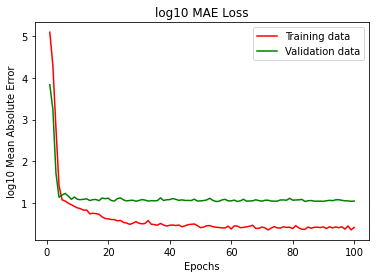

In [27]:
plt.figure()
plt.plot(range(1,101),train_mae_loss_list,'-r',label="Training data")
plt.plot(range(1,101),val_mae_loss_list,'-g',label="Validation data")
plt.gca().set_xlabel("Epochs")
plt.gca().set_ylabel("log10 Mean Absolute Error")
plt.gca().set_title("log10 MAE Loss")
plt.legend()

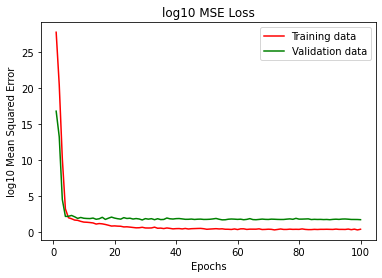

In [28]:
plt.figure()
plt.plot(range(1,101),train_mse_loss_list,'-r',label="Training data")
plt.plot(range(1,101),val_mse_loss_list,'-g',label="Validation data")
plt.gca().set_xlabel("Epochs")
plt.gca().set_ylabel("log10 Mean Squared Error")
plt.gca().set_title("log10 MSE Loss")
plt.legend()

In [29]:
def abs_err(x,y):
    return np.abs(x-y)
def reg_err(x,y):
    return x-y

In [30]:
# Evaluate training distribution
model.eval()
train_mae_loss = []
train_reg_loss = []

for image, label in tqdm(train_loader,desc="Train data: "):
    # Send variables to device
    image = image.to(device)
    label = label.to(device)
    # Run model
    pred = model(image)
    # Move variables to cpu
    pred = pred.cpu().squeeze().detach()
    label = label.cpu().squeeze().detach()
#     print(pred.shape)
#     print(abs_err(pred,label))
    # Compute loss
    train_mae_loss = np.concatenate((train_mae_loss, abs_err(pred,label)))
    train_reg_loss = np.concatenate((train_reg_loss, reg_err(pred,label)))


Train data: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:05<00:00,  8.60it/s]


Text(0.5, 0, 'log10 absolute error')

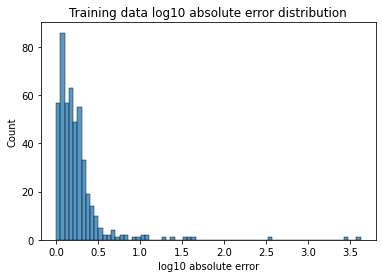

In [31]:
# Plot absolute error (log) distribution for model
sns.histplot(train_mae_loss)#, kde=True)
plt.gca().set_title("Training data log10 absolute error distribution")
plt.gca().set_xlabel("log10 absolute error")

Text(0.5, 0, 'log10 error')

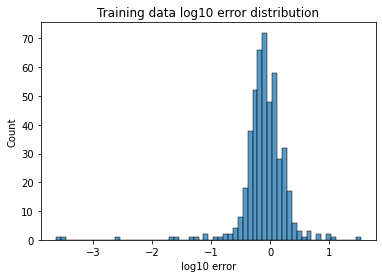

In [32]:
sns.histplot(train_reg_loss)#, kde=True)
plt.gca().set_title("Training data log10 error distribution")
plt.gca().set_xlabel("log10 error")

In [33]:
# Evaluate validation distribution
model.eval()
val_mae_loss = []
val_reg_loss = []

for image, label in tqdm(val_loader,desc="Validation data: "):
    # Send variables to device
    image = image.to(device)
    label = label.to(device)
    # Run model
    pred = model(image)
    # Move variables to cpu
    pred = pred.cpu().squeeze().detach()
    label = label.cpu().squeeze().detach()
#     print(pred.shape)
#     print(abs_err(pred,label))
    # Compute loss
    val_mae_loss = np.concatenate((val_mae_loss, abs_err(pred,label)))
    val_reg_loss = np.concatenate((val_reg_loss, reg_err(pred,label)))


Validation data: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Text(0.5, 0, 'log10 absolute error')

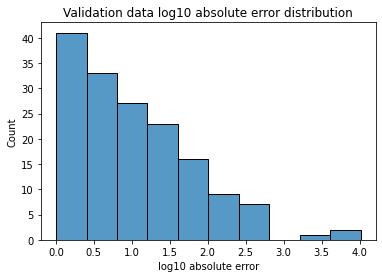

In [34]:
sns.histplot(val_mae_loss)
plt.gca().set_title("Validation data log10 absolute error distribution")
plt.gca().set_xlabel("log10 absolute error")

Text(0.5, 0, 'log10 error')

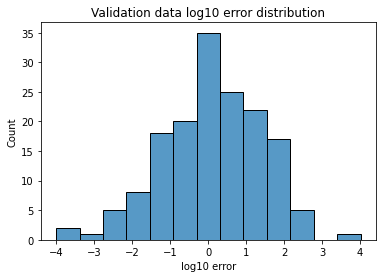

In [35]:
sns.histplot(val_reg_loss)
plt.gca().set_title("Validation data log10 error distribution")
plt.gca().set_xlabel("log10 error")

In [36]:
# Evaluate test distribution
model.eval()
test_mae_loss = []
test_reg_loss = []

for image, label in tqdm(test_loader,desc="Test data: "):
    # Send variables to device
    image = image.to(device)
    label = label.to(device)
    # Run model
    pred = model(image)
    # Move variables to cpu
    pred = pred.cpu().squeeze().detach()
    label = label.cpu().squeeze().detach()
#     print(pred.shape)
#     print(abs_err(pred,label))
    # Compute loss
    test_mae_loss = np.concatenate((test_mae_loss, abs_err(pred,label)))
    test_reg_loss = np.concatenate((test_reg_loss, reg_err(pred,label)))

Test data: 100%|█████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Text(0.5, 0, 'log10 absolute error')

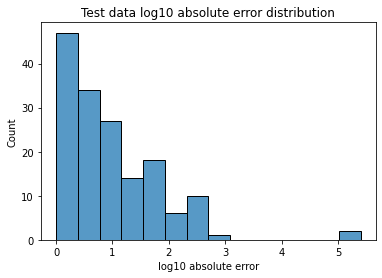

In [37]:
sns.histplot(test_mae_loss)
plt.gca().set_title("Test data log10 absolute error distribution")
plt.gca().set_xlabel("log10 absolute error")

Text(0.5, 0, 'log10 error')

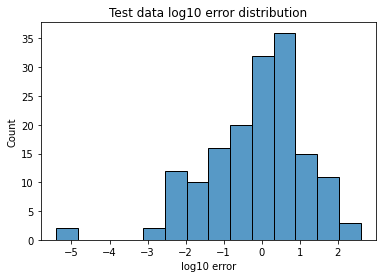

In [38]:
sns.histplot(test_reg_loss)
plt.gca().set_title("Test data log10 error distribution")
plt.gca().set_xlabel("log10 error")